In [1]:
import numpy as np
from scipy.optimize import minimize
import pickle
from itertools import combinations
from API.functions3D import *
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
with open('PKL/saved_dictionary.pkl', 'rb') as p_array_2d_dict_file:
    p_array_2d_dict = pickle.load(p_array_2d_dict_file)
    
with open('PKL/saved_camera_dictionary.pkl', 'rb') as camera_dict_file:
    camera_dict = pickle.load(camera_dict_file)
    
with open('PKL/saved_points_reconstructed_noisy_linear.pkl', 'rb') as recon_file:
    linear_estimates = pickle.load(recon_file)
    
with open('PKL/saved_points_reconstructed_linear.pkl', 'rb') as rec_file:
    noiseless_linear_estimates = pickle.load(rec_file)

# 2D Image Dataset


|![alt](figs/skeleton_cam1_nonHPR.png) |![alt](figs/skeleton_cam2_nonHPR.png)|
|-|-|
|![alt](figs/skeleton_cam3_nonHPR.png) | ![alt](figs/skeleton_cam4_nonHPR.png)

# $L_1$

In [3]:
def objective(x):
    max_error = 0
#     print(P1,P2)
    for i in range(num_cameras):
        ratio = P1 @ x / (P2 @ x + 1e-10)  # Adding a small value to avoid division by zero
        error = np.linalg.norm(u[i].flatten() - ratio.flatten(), np.inf)
        if error > max_error:
            max_error = error
        break
    return max_error

In [4]:
def objective_cumulative(x):
    max_error = np.zeros(num_cameras)
    for i in range(num_cameras):
        P1_i = P1[i]
        P2_i = P2[i]
        u_i = u[i]
        P2i_x = P2_i @ x + 1e-10  # Adding a small value to avoid division by zero
        ratio = P1_i @ x / P2i_x
        error = np.linalg.norm(u_i.flatten() - ratio.flatten(), ord=1)
        if error > max_error[i]:
            max_error[i] = error
    return max(max_error)

### Single Point Reconstruction

In [5]:
i=2
bounds = [(-1000, 1000), (-1000, 1000), (-1000, 1000),  (-1000, 1000)]

point_range=len(p_array_2d_dict[0]['Data'])
num_cameras=len(camera_dict)

In [6]:
P1, P2, u = [], [], []

for j in range(num_cameras):
    P1.append(camera_dict[j]['Camera Matrix'][:-1])
    P2.append(camera_dict[j]['Camera Matrix'][2:])
    u.append(p_array_2d_dict[j]['Data'][i])

In [7]:
for j in range(num_cameras):
    
    hetero_point=linear_estimates[i]
    x0 = [hetero_point[0],  hetero_point[1], hetero_point[2], 1]
    
    result = minimize(objective_cumulative, x0, bounds=bounds, method='L-BFGS-B')
    optimal_x = result.x
    hetero_optimal=[optimal_x[0]/optimal_x[3], optimal_x[1]/optimal_x[3], optimal_x[2]/optimal_x[3]]
    
print(hetero_optimal)
print(linear_estimates[i])

[145.7355693165707, 133.14911358895662, 519.9285722184433]
[135.69728954 123.97791452 484.11567738]


### Point cloud reconstruction

In [8]:
random_integers = np.random.choice(range(10000), 1000, replace=False)
downsampled_batch = np.sort(random_integers)
len(downsampled_batch)

1000

In [9]:
optimal_points = []

In [10]:
for i in downsampled_batch:
    
    P1, P2, u = [], [], []

    for j in range(num_cameras):
        P1.append(camera_dict[j]['Camera Matrix'][:-1])
        P2.append(camera_dict[j]['Camera Matrix'][2:])
        u.append(p_array_2d_dict[j]['Data'][i])
    
    
    
    for j in range(num_cameras):
        hetero_point=linear_estimates[i]
        x0 = [hetero_point[0],  hetero_point[1], hetero_point[2], 1]

        result = minimize(objective_cumulative, x0, bounds=bounds, method='L-BFGS-B')
        optimal_x = result.x
        hetero_optimal=[optimal_x[0]/optimal_x[3], optimal_x[1]/optimal_x[3], optimal_x[2]/optimal_x[3]]    
        
    optimal_points.append(hetero_optimal)



"""
This block for 10000 points will take around 12.44 minutes to resolve
"""

'\nThis block for 10000 points will take around 12.44 minutes to resolve\n'

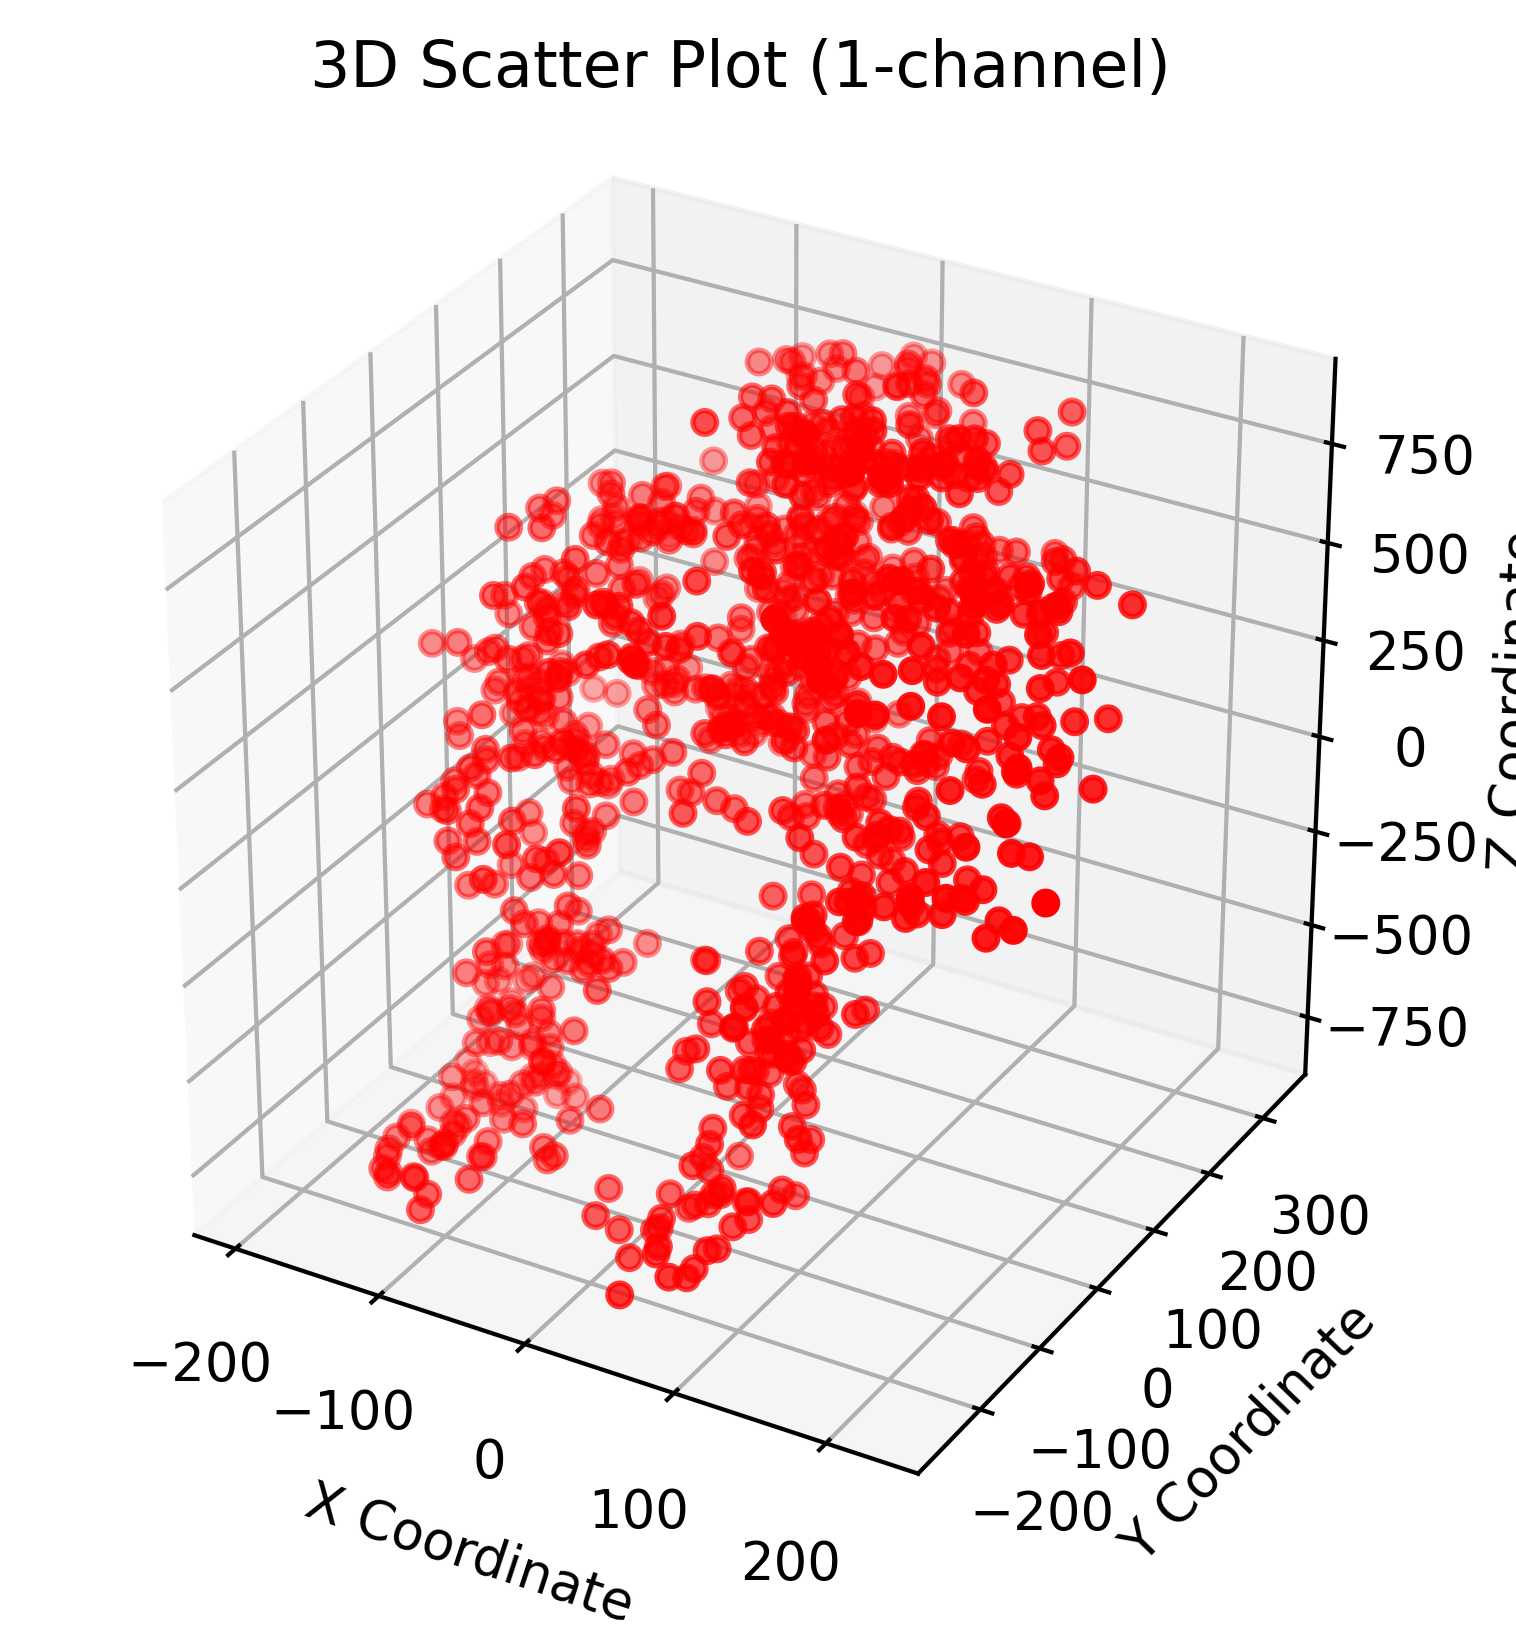

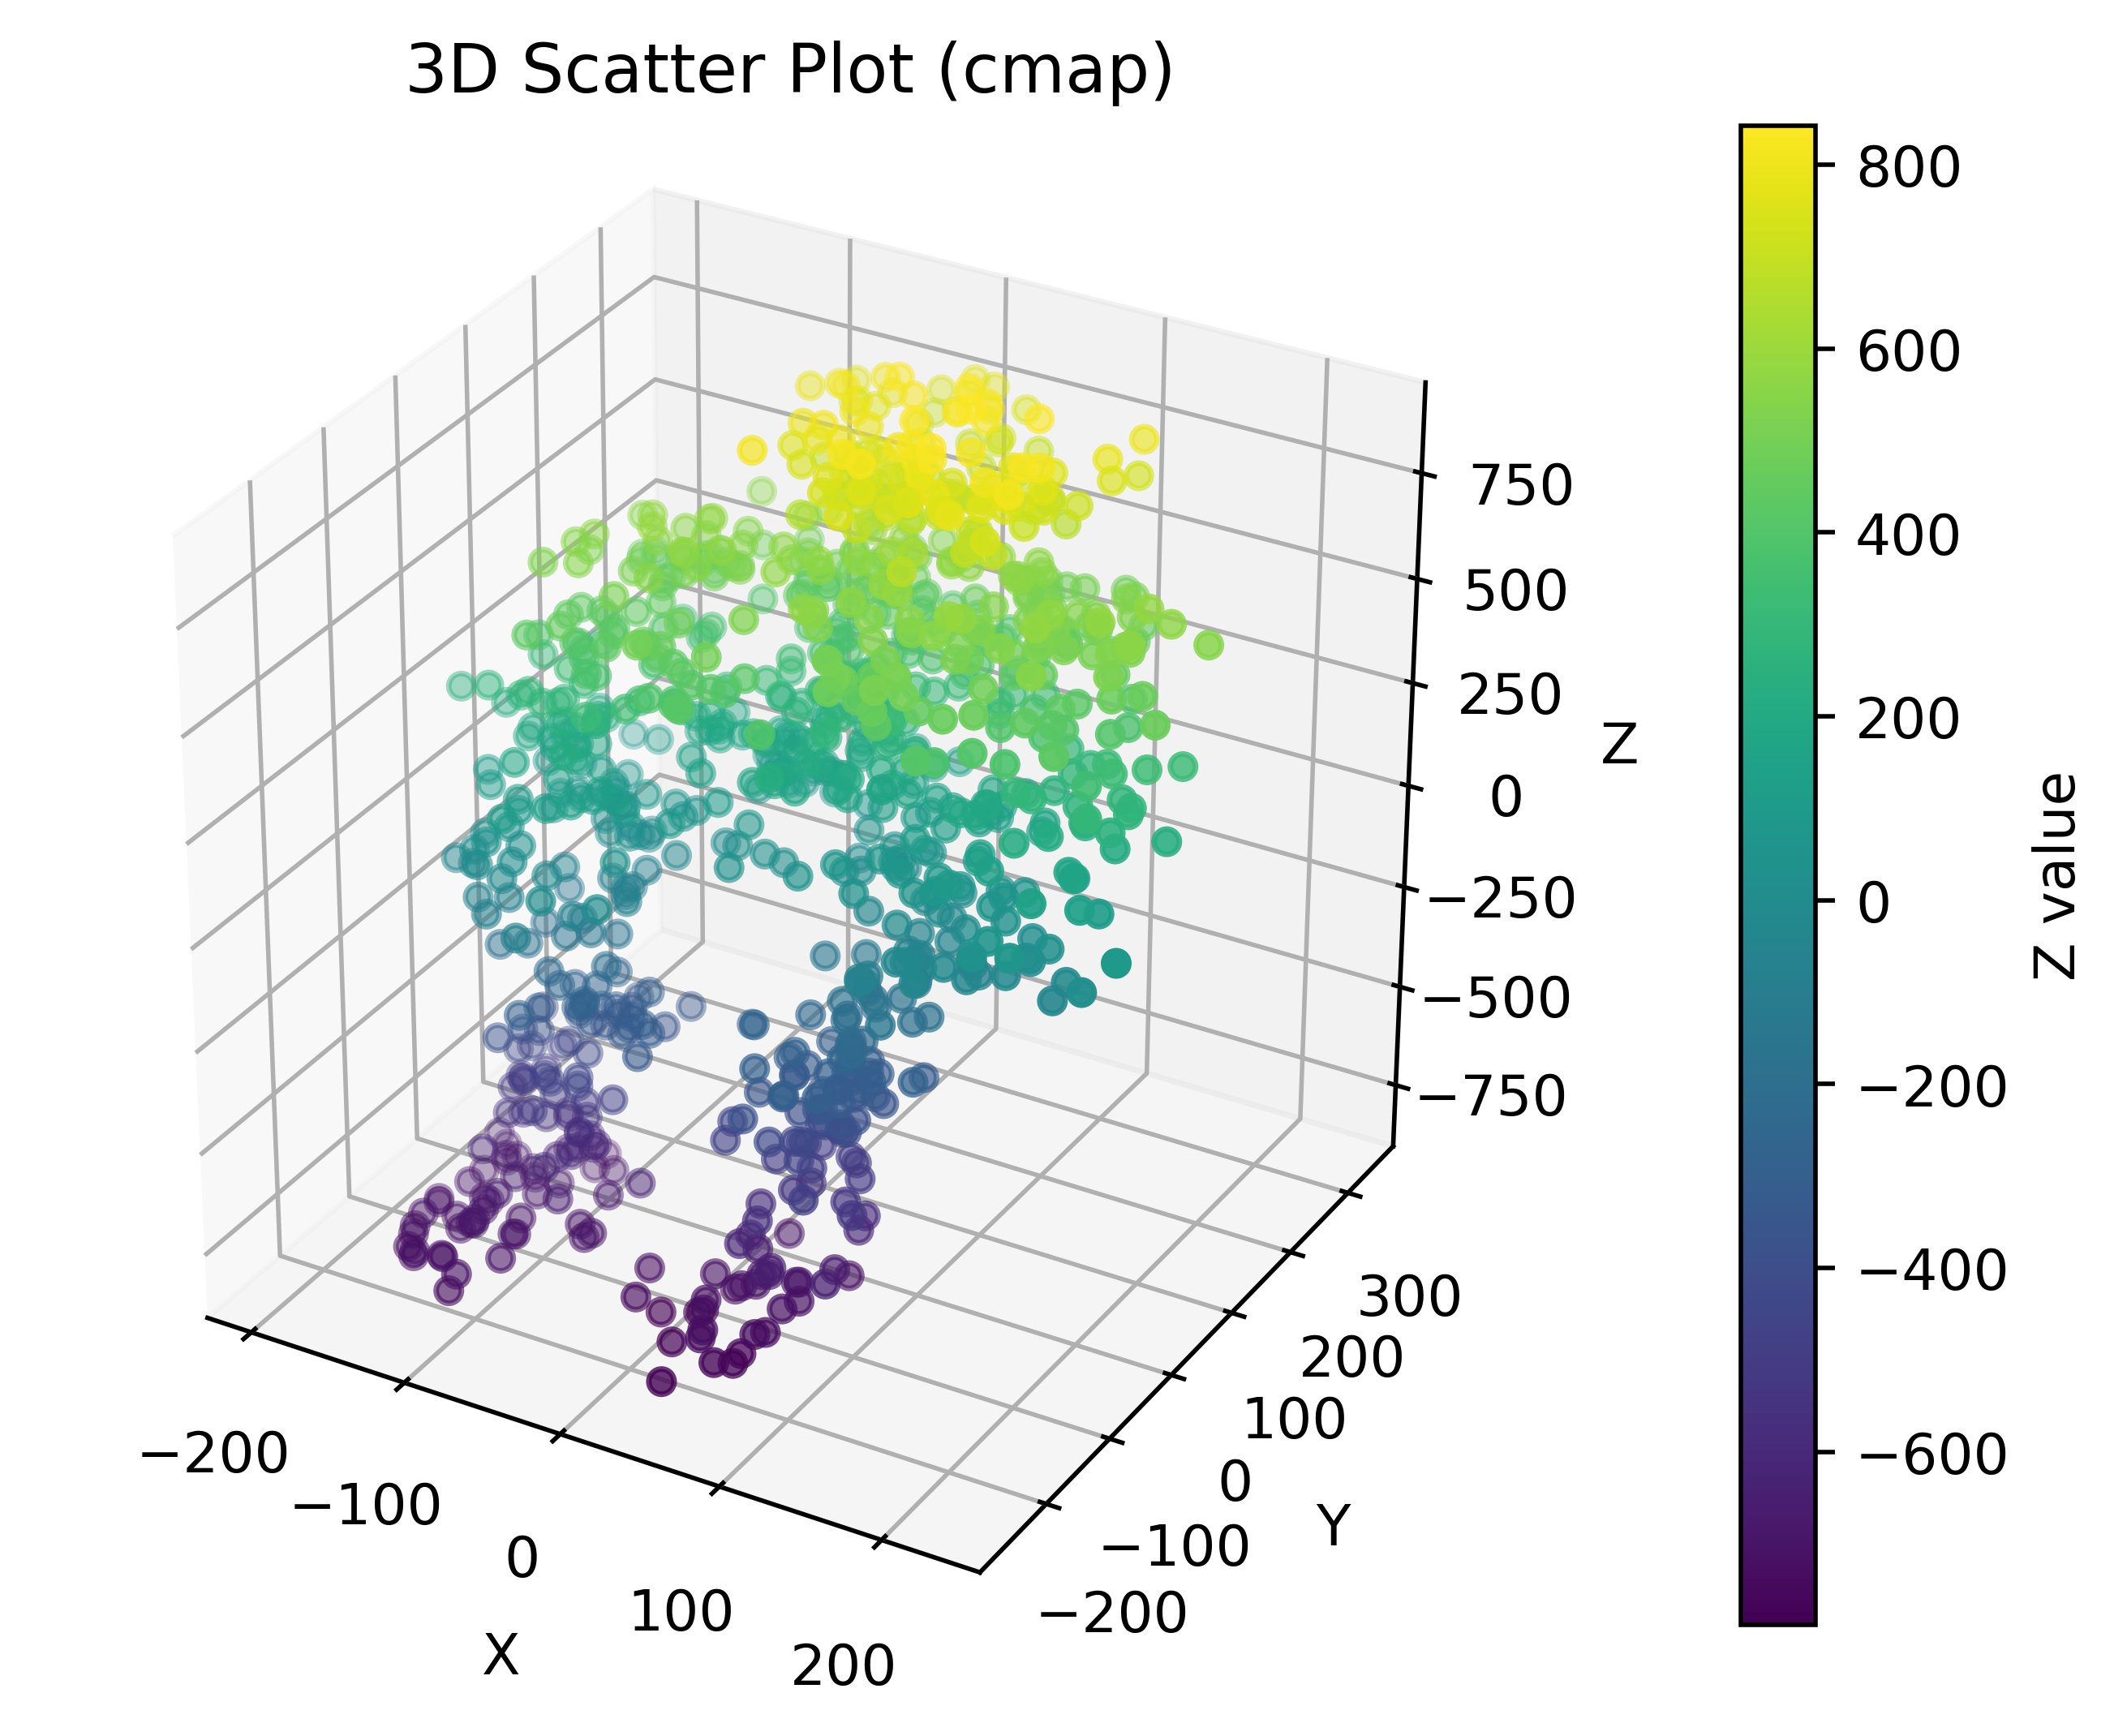

In [11]:
visualize_polygon_from_arr_using_plt(optimal_points)

In [12]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(optimal_points))
o3d.visualization.draw_geometries([pcd])

### Results from a dataset with 10000 points 

In [13]:
with open('PKL/saved_points_reconstructed_L1.pkl', 'rb') as L1_reconstructed_file:
    L1_reconstructed_points = pickle.load(L1_reconstructed_file)

In [14]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(L1_reconstructed_points)
o3d.visualization.draw_geometries([pcd])

# $L_\infty$

In [15]:
with open('PKL/saved_dictionary.pkl', 'rb') as p_array_2d_dict_file:
    p_array_2d_dict = pickle.load(p_array_2d_dict_file)
    
with open('PKL/saved_camera_dictionary.pkl', 'rb') as camera_dict_file:
    camera_dict = pickle.load(camera_dict_file)
    
with open('PKL/saved_points_reconstructed_noisy_linear.pkl', 'rb') as recon_file:
    linear_estimates = pickle.load(recon_file)
    
with open('PKL/saved_points_reconstructed_linear.pkl', 'rb') as rec_file:
    noiseless_linear_estimates = pickle.load(rec_file)

In [16]:
def objective_cumulative(x):
    max_error = np.zeros(num_cameras)
    for i in range(num_cameras):
        P1_i = P1[i]
        P2_i = P2[i]
        u_i = u[i]
        P2i_x = P2_i @ x + 1e-10  # Adding a small value to avoid division by zero
        ratio = P1_i @ x / P2i_x
        error = np.linalg.norm(u_i.flatten() - ratio.flatten(), np.inf)
        if error > max_error[i]:
            max_error[i] = error
    return max(max_error)

### Single-point Reconstruction

In [17]:
i=2
bounds = [(-1000, 1000), (-1000, 1000), (-1000, 1000),  (-1000, 1000)]

point_range=len(p_array_2d_dict[0]['Data'])
num_cameras=len(camera_dict)

In [18]:
P1, P2, u = [], [], []

for j in range(num_cameras):
    P1.append(camera_dict[j]['Camera Matrix'][:-1])
    P2.append(camera_dict[j]['Camera Matrix'][2:])
    u.append(p_array_2d_dict[j]['Data'][i])

In [19]:
for j in range(num_cameras):
    
    hetero_point=linear_estimates[i]
    x0 = [hetero_point[0],  hetero_point[1], hetero_point[2], 1]
    
    result = minimize(objective_cumulative, x0, bounds=bounds, method='L-BFGS-B')
    optimal_x = result.x
    hetero_optimal=[optimal_x[0]/optimal_x[3], optimal_x[1]/optimal_x[3], optimal_x[2]/optimal_x[3]]
    
print(hetero_optimal)
print(linear_estimates[i])

[142.01929661456592, 129.75380267620167, 506.67027458271826]
[135.69728954 123.97791452 484.11567738]


### Point Cloud Reconstruction

In [20]:
optimal_points = []

In [21]:
random_integers = np.random.choice(range(10000), 1000, replace=False)
downsampled_batch = np.sort(random_integers)
len(downsampled_batch)

1000

In [22]:
for i in downsampled_batch:
    
    P1, P2, u = [], [], []

    for j in range(num_cameras):
        P1.append(camera_dict[j]['Camera Matrix'][:-1])
        P2.append(camera_dict[j]['Camera Matrix'][2:])
        u.append(p_array_2d_dict[j]['Data'][i])
    
    
    
    for j in range(num_cameras):
        hetero_point=linear_estimates[i]
        x0 = [hetero_point[0],  hetero_point[1], hetero_point[2], 1]

        result = minimize(objective_cumulative, x0, bounds=bounds, method='L-BFGS-B')
        optimal_x = result.x
        hetero_optimal=[optimal_x[0]/optimal_x[3], optimal_x[1]/optimal_x[3], optimal_x[2]/optimal_x[3]]    
        
#     print(hetero_optimal)
#     print(linear_estimates[i])
    optimal_points.append(hetero_optimal)
#     print(i)


"""
This block for 10000 points will take around 26.56 minutes to resolve
"""

'\nThis block for 10000 points will take around 26.56 minutes to resolve\n'

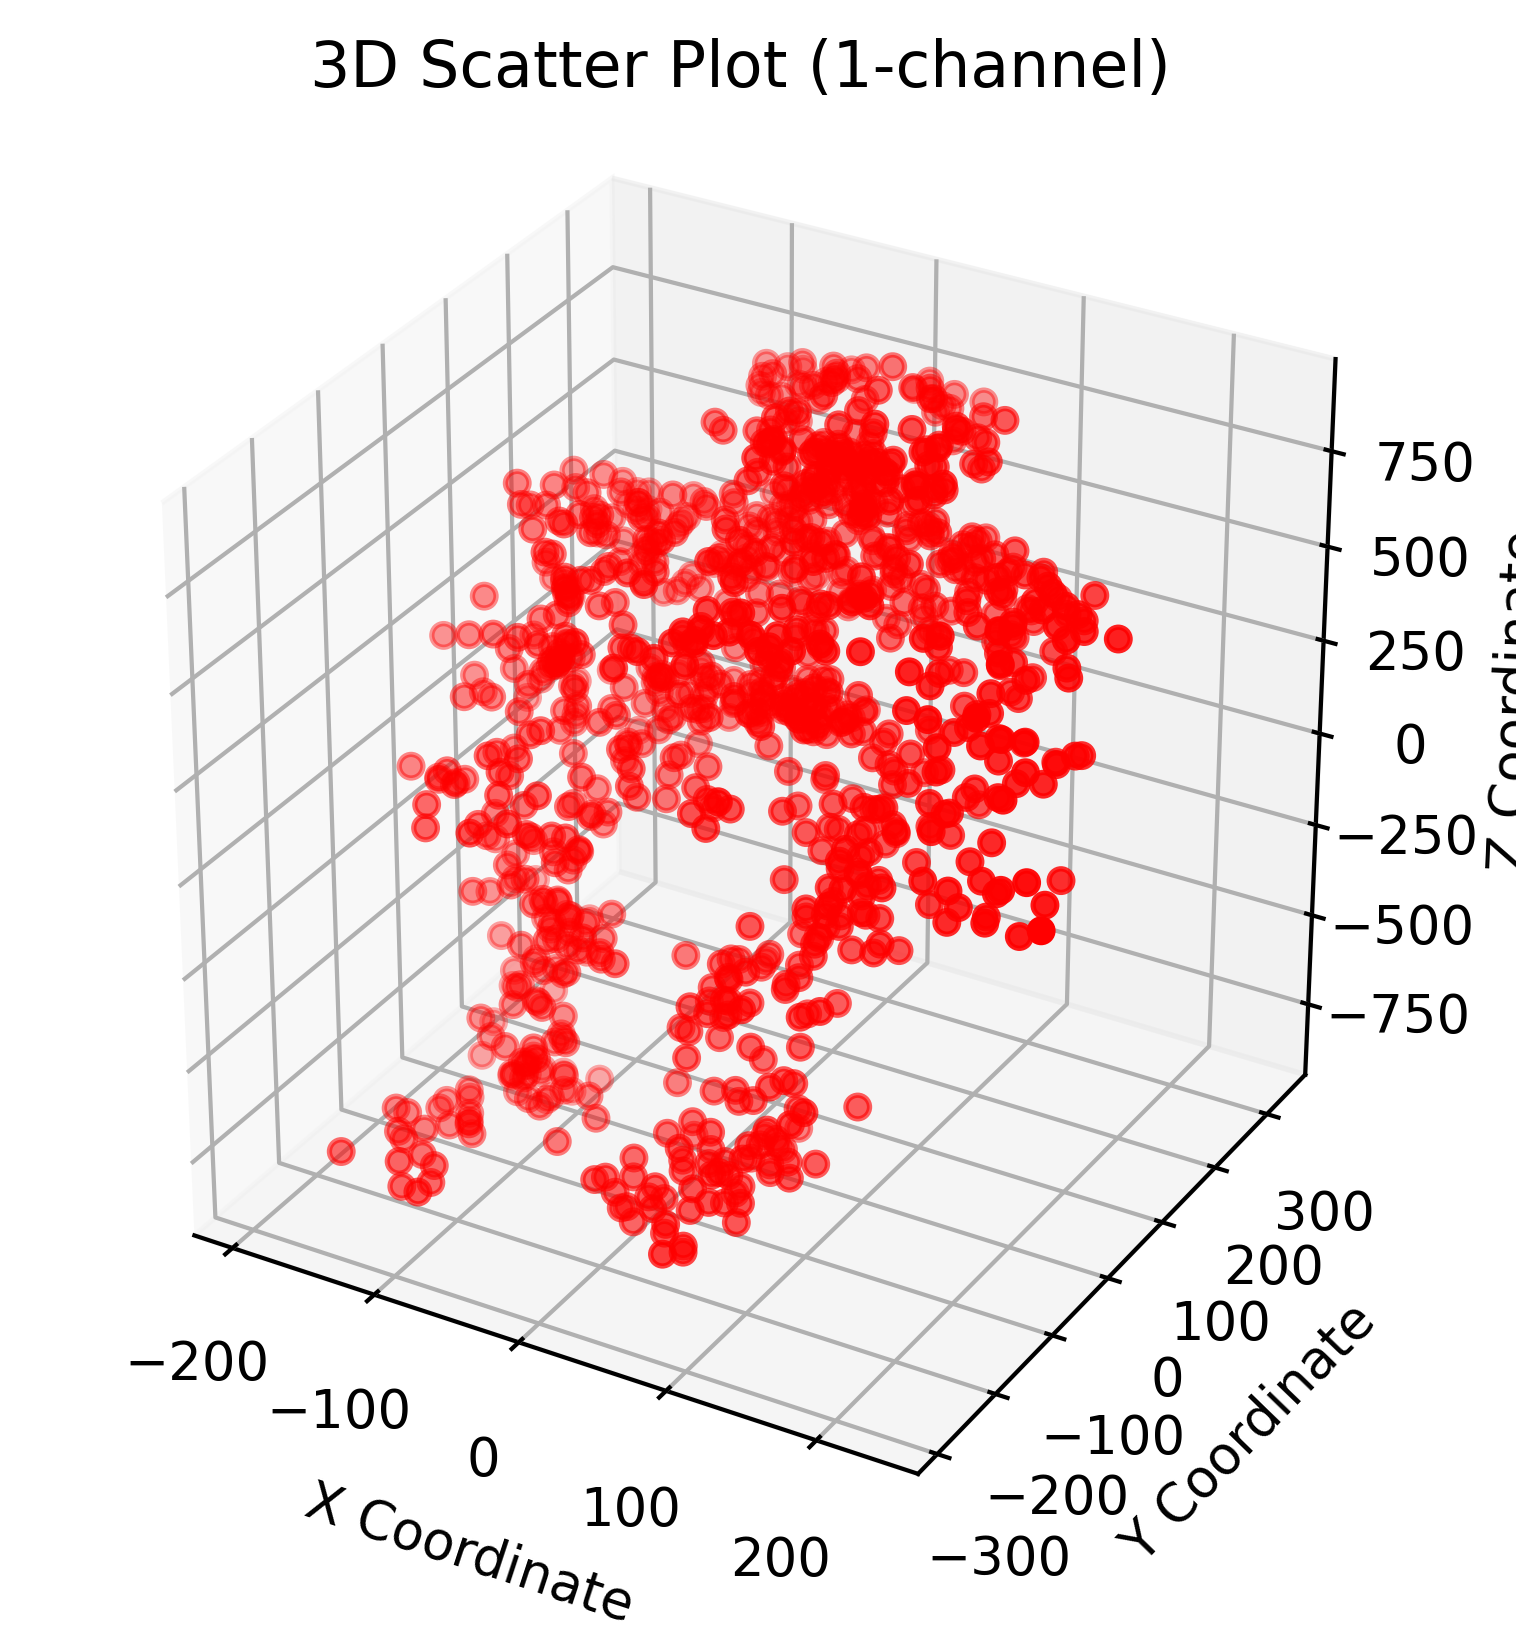

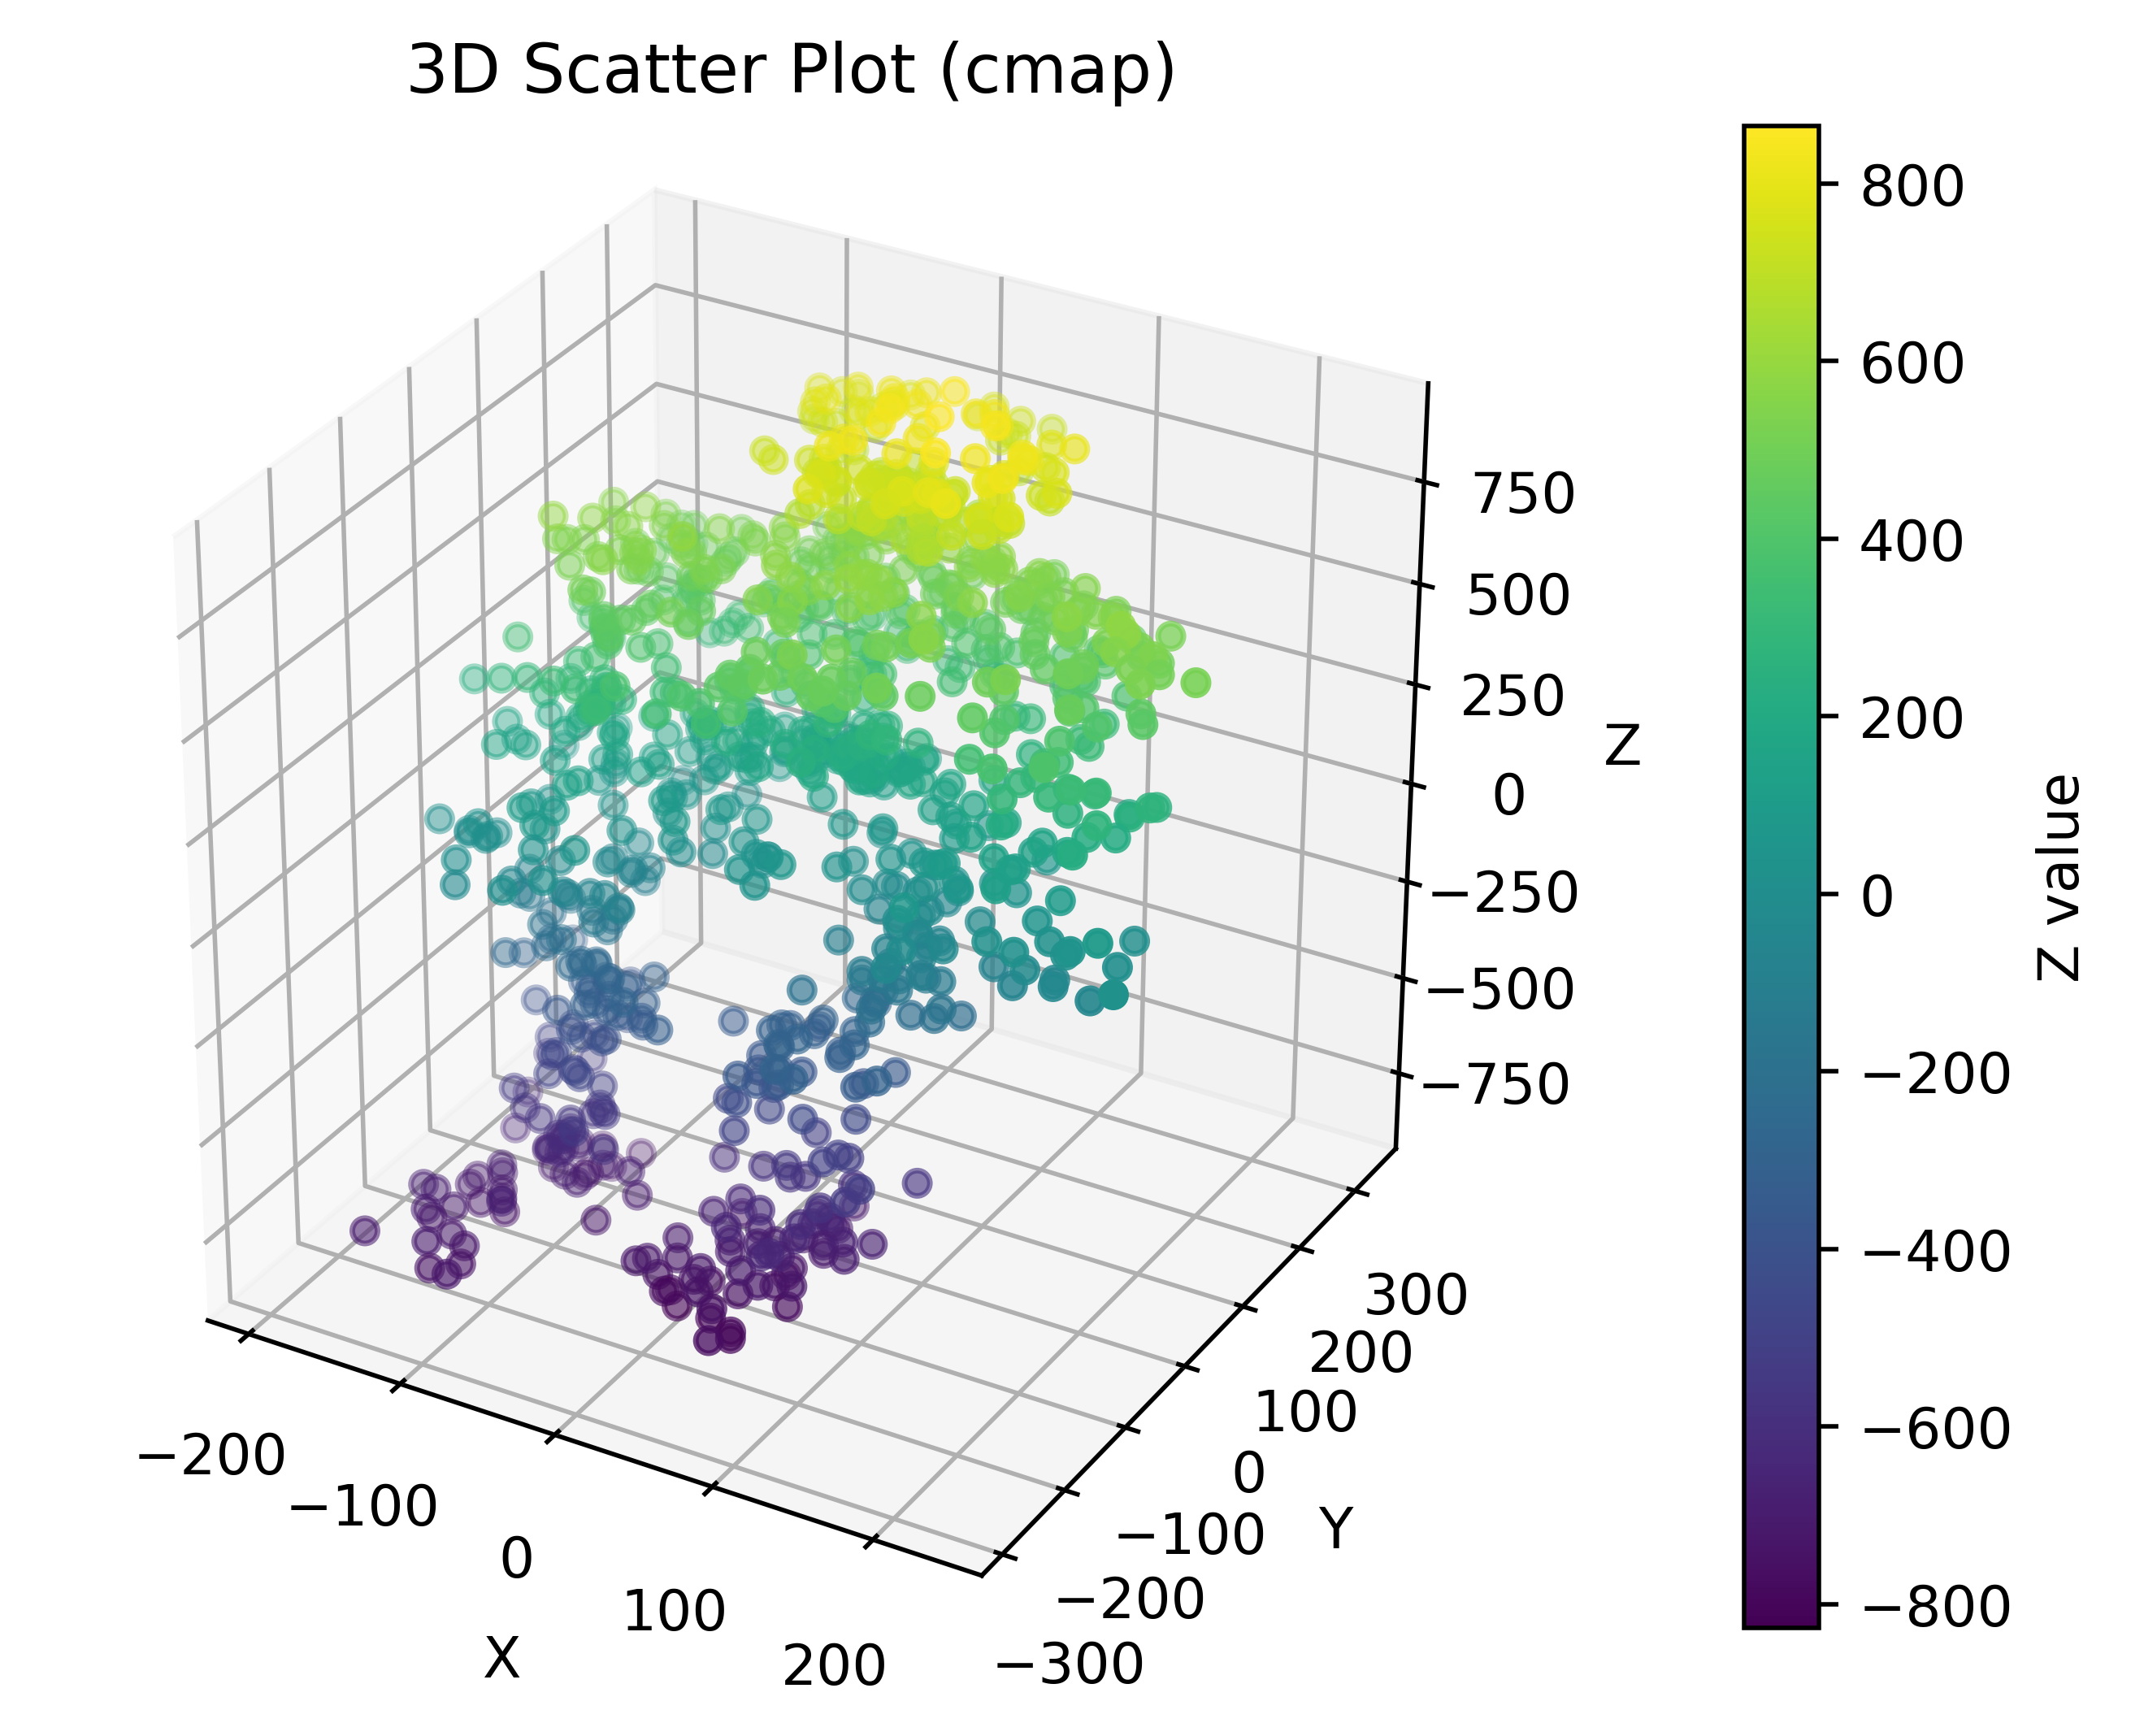

In [23]:
visualize_polygon_from_arr_using_plt(optimal_points)

In [24]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(optimal_points))
o3d.visualization.draw_geometries([pcd])

### Results from a dataset with 10000 points

In [25]:
with open('PKL/saved_points_reconstructed_L_inf.pkl', 'rb') as L_inf_reconstructed_file:
    L_inf_reconstructed_points = pickle.load(L_inf_reconstructed_file)

In [26]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(L_inf_reconstructed_points)
o3d.visualization.draw_geometries([pcd])

# LMS

In [27]:
def convert_reprojection_errors(A, b, c, d, x, delta_x):
    u = np.dot(A, x) + b
    w = np.dot(c.T, x) + d
    return u / (w + 1e-10)

In [28]:
def is_intersection(r1, r2):
    return np.any(np.isclose(r1, r2))

In [29]:
def is_tangent(r1, r2):
    return np.allclose(r1, r2)

In [30]:
def swap_order(list_, idx1, idx2):
    list_[idx1], list_[idx2] = list_[idx2], list_[idx1]

In [31]:
def DESCENTDIR(A, b, c, d, x_hat, p_array_2d_dict, camera_dict, linear_estimates):
    r_hat = np.median([np.max(np.abs(convert_reprojection_errors(Ai, bi, ci, di, x_hat, None))) for Ai, bi, ci, di in zip(A, b, c, d)])
    A_active = [p for p in range(len(A)) if np.isclose(np.max(np.abs(convert_reprojection_errors(A[p], b[p], c[p], d[p], x_hat, None))), r_hat)]
    J = [(p, q) for p in A_active for q in A_active if p != q and np.isclose(np.max(np.abs(convert_reprojection_errors(A[p], b[p], c[p], d[p], x_hat, None))), np.max(np.abs(convert_reprojection_errors(A[q], b[q], c[q], d[q], x_hat, None))))]
    N = [-(Ai.T @ Ai - r_hat * (ci @ ci.T)) for Ai, ci in zip(A, c)]
    N=1
    result = minimize(objective_cumulative, x_hat, bounds=bounds, method='L-BFGS-B')
    delta_x = None
    if len(N) == 1:
        delta_x = N[0][:, 0]
    elif len(N) == 2:
        delta_x = N[0][:, 0] + N[1][:, 0]
    else:
        for nu, nv, nw in combinations(N, 3):
            y = np.cross(nu[:, 0], nv[:, 0]) + np.cross(nv[:, 0], nw[:, 0]) + np.cross(nw[:, 0], nu[:, 0])
            s = np.dot(nu[:, 0].T, y) / np.linalg.norm(np.dot(nu[:, 0].T, y))
            y = s * y
            if all(np.dot(y.T, n[:, 0]) > 0 for n in N):
                delta_x = y
                break
    
    return delta_x

In [32]:
def STEPSIZE(A, b, c, d, x_hat, delta_x):
    reprojection_errors = [np.max(np.abs(convert_reprojection_errors(Ai, bi, ci, di, x_hat, delta_x))) for Ai, bi, ci, di in zip(A, b, c, d)]
    alpha = 0
    event_points = sorted([(e, idx) for idx, re in enumerate(reprojection_errors) for e in re])
    list_indices = np.argsort([-re for re in reprojection_errors])
    K = len(A) // 2
    r_star = reprojection_errors[list_indices[K]]
    
    for e, idx in event_points:
        if is_intersection(reprojection_errors[idx], reprojection_errors[idx - 1]):
            if not is_tangent(reprojection_errors[idx], reprojection_errors[idx - 1]):
                swap_order(list_indices, idx, idx - 1)
        if idx in list_indices[K] or (idx - 1) in list_indices[K]:
            if r_star > reprojection_errors[idx]:
                alpha = e
                r_star = reprojection_errors[idx]
    
    return alpha

In [33]:
def QSWEEP(A, b, c, d, x_hat):
    delta_x = DESCENT_DIR(A, b, c, d, x_hat, p_array_2d_dict, camera_dict, linear_estimates)
    x_hat_original=np.copy(x_hat)
    while delta_x is not None:
        alpha = STEPSIZE(A, b, c, d, x_hat, delta_x)
        x_hat = x_hat + alpha * delta_x
        delta_x = DESCENTDIR(A, b, c, d, x_hat)
    x_hat=rescale(x_hat, x_hat_original)
    return x_hat

In [34]:
def equivalent_matrices(u_i, P_i):
    w = 1
    d_i = P_i[2][3]*w
    c_i = np.array([P_i[2][0], P_i[2][1], P_i[2][2]])
    A_i = np.array([[u_i[0]*P_i[2][0]+P_i[0][0], u_i[0]*P_i[2][1]+P_i[0][1], u_i[0]*P_i[2][2]+P_i[0][2]]
                    ,[u_i[1]*P_i[2][0]+P_i[1][0], u_i[1]*P_i[2][1]+P_i[1][1], u_i[1]*P_i[2][2]+P_i[1][2]]])
    
    b_i = np.array([np.array([u_i[0]*d_i+P_i[0][3]*w]), 
                    np.array([u_i[1]*d_i+P_i[1][3]*w])])
    
    return A_i.reshape(2,3), b_i.reshape(2,1), c_i.reshape(3,1), d_i

In [35]:
qsweep_reconstructed_points=[]

random_integers = np.random.choice(range(10000), 1000, replace=False)
downsampled_batch_2 = np.sort(random_integers)

In [36]:
for i in downsampled_batch_2:
    
    P1, P2, u = [], [], []

    for j in range(num_cameras):
        P1.append(camera_dict[j]['Camera Matrix'][:-1])
        P2.append(camera_dict[j]['Camera Matrix'][2:])
        u.append(p_array_2d_dict[j]['Data'][i])
        
    for j in range(num_cameras):
        
        x_hat=linear_estimates[i]       
        A, b, c, d = equivalent_matrices(p_array_2d_dict[j]['Data'][i], camera_dict[j]['Camera Matrix'])  
        hetero_optimal=QSWEEP(A, b, c, d, x_hat)

    qsweep_reconstructed_points.append(hetero_optimal)


"""
This block for 10000 points will take around 6.11 minutes to solve
"""

'\nThis block for 10000 points will take around 6.11 minutes to solve\n'

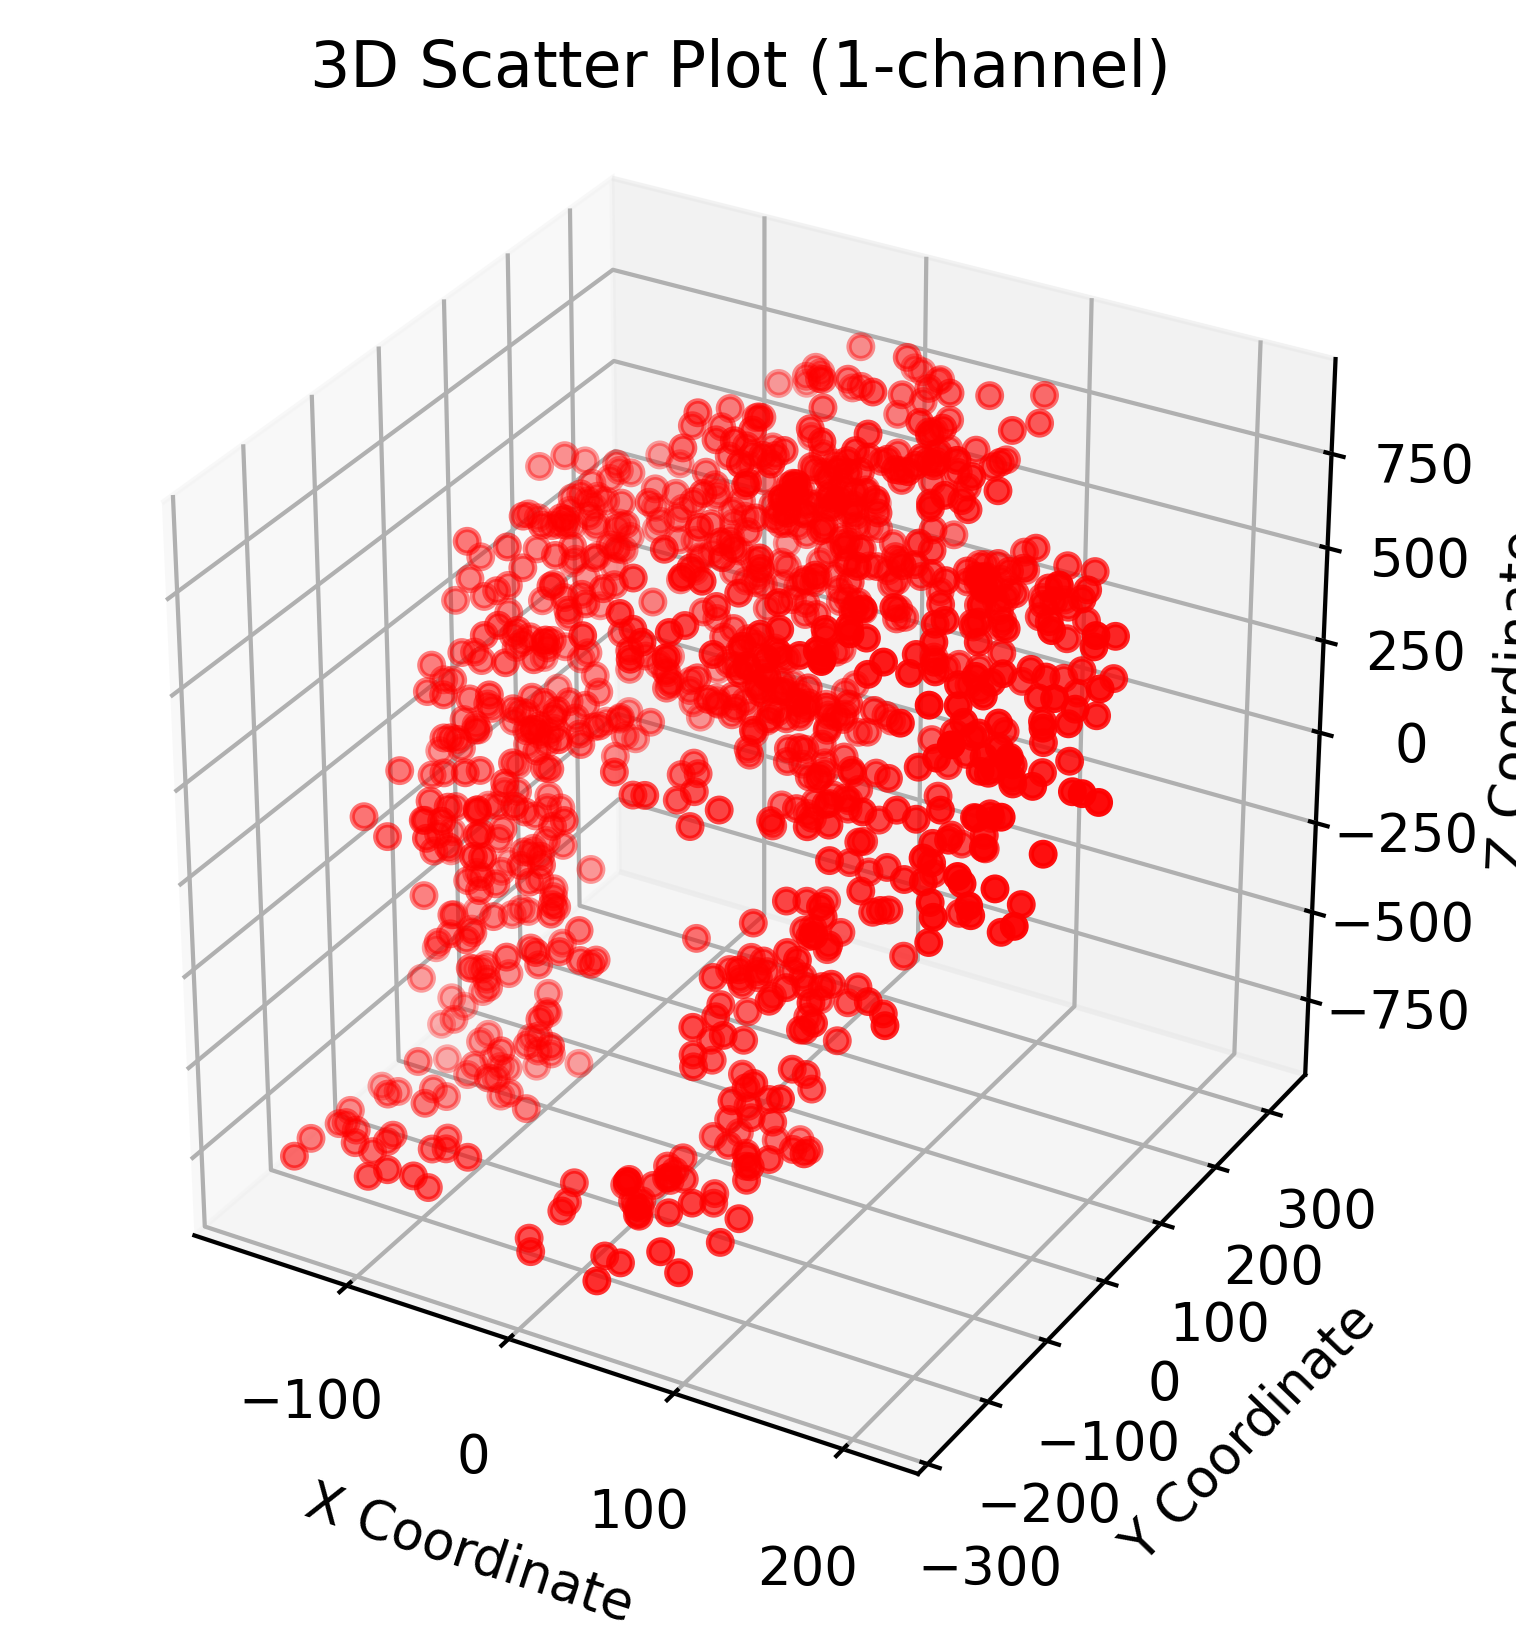

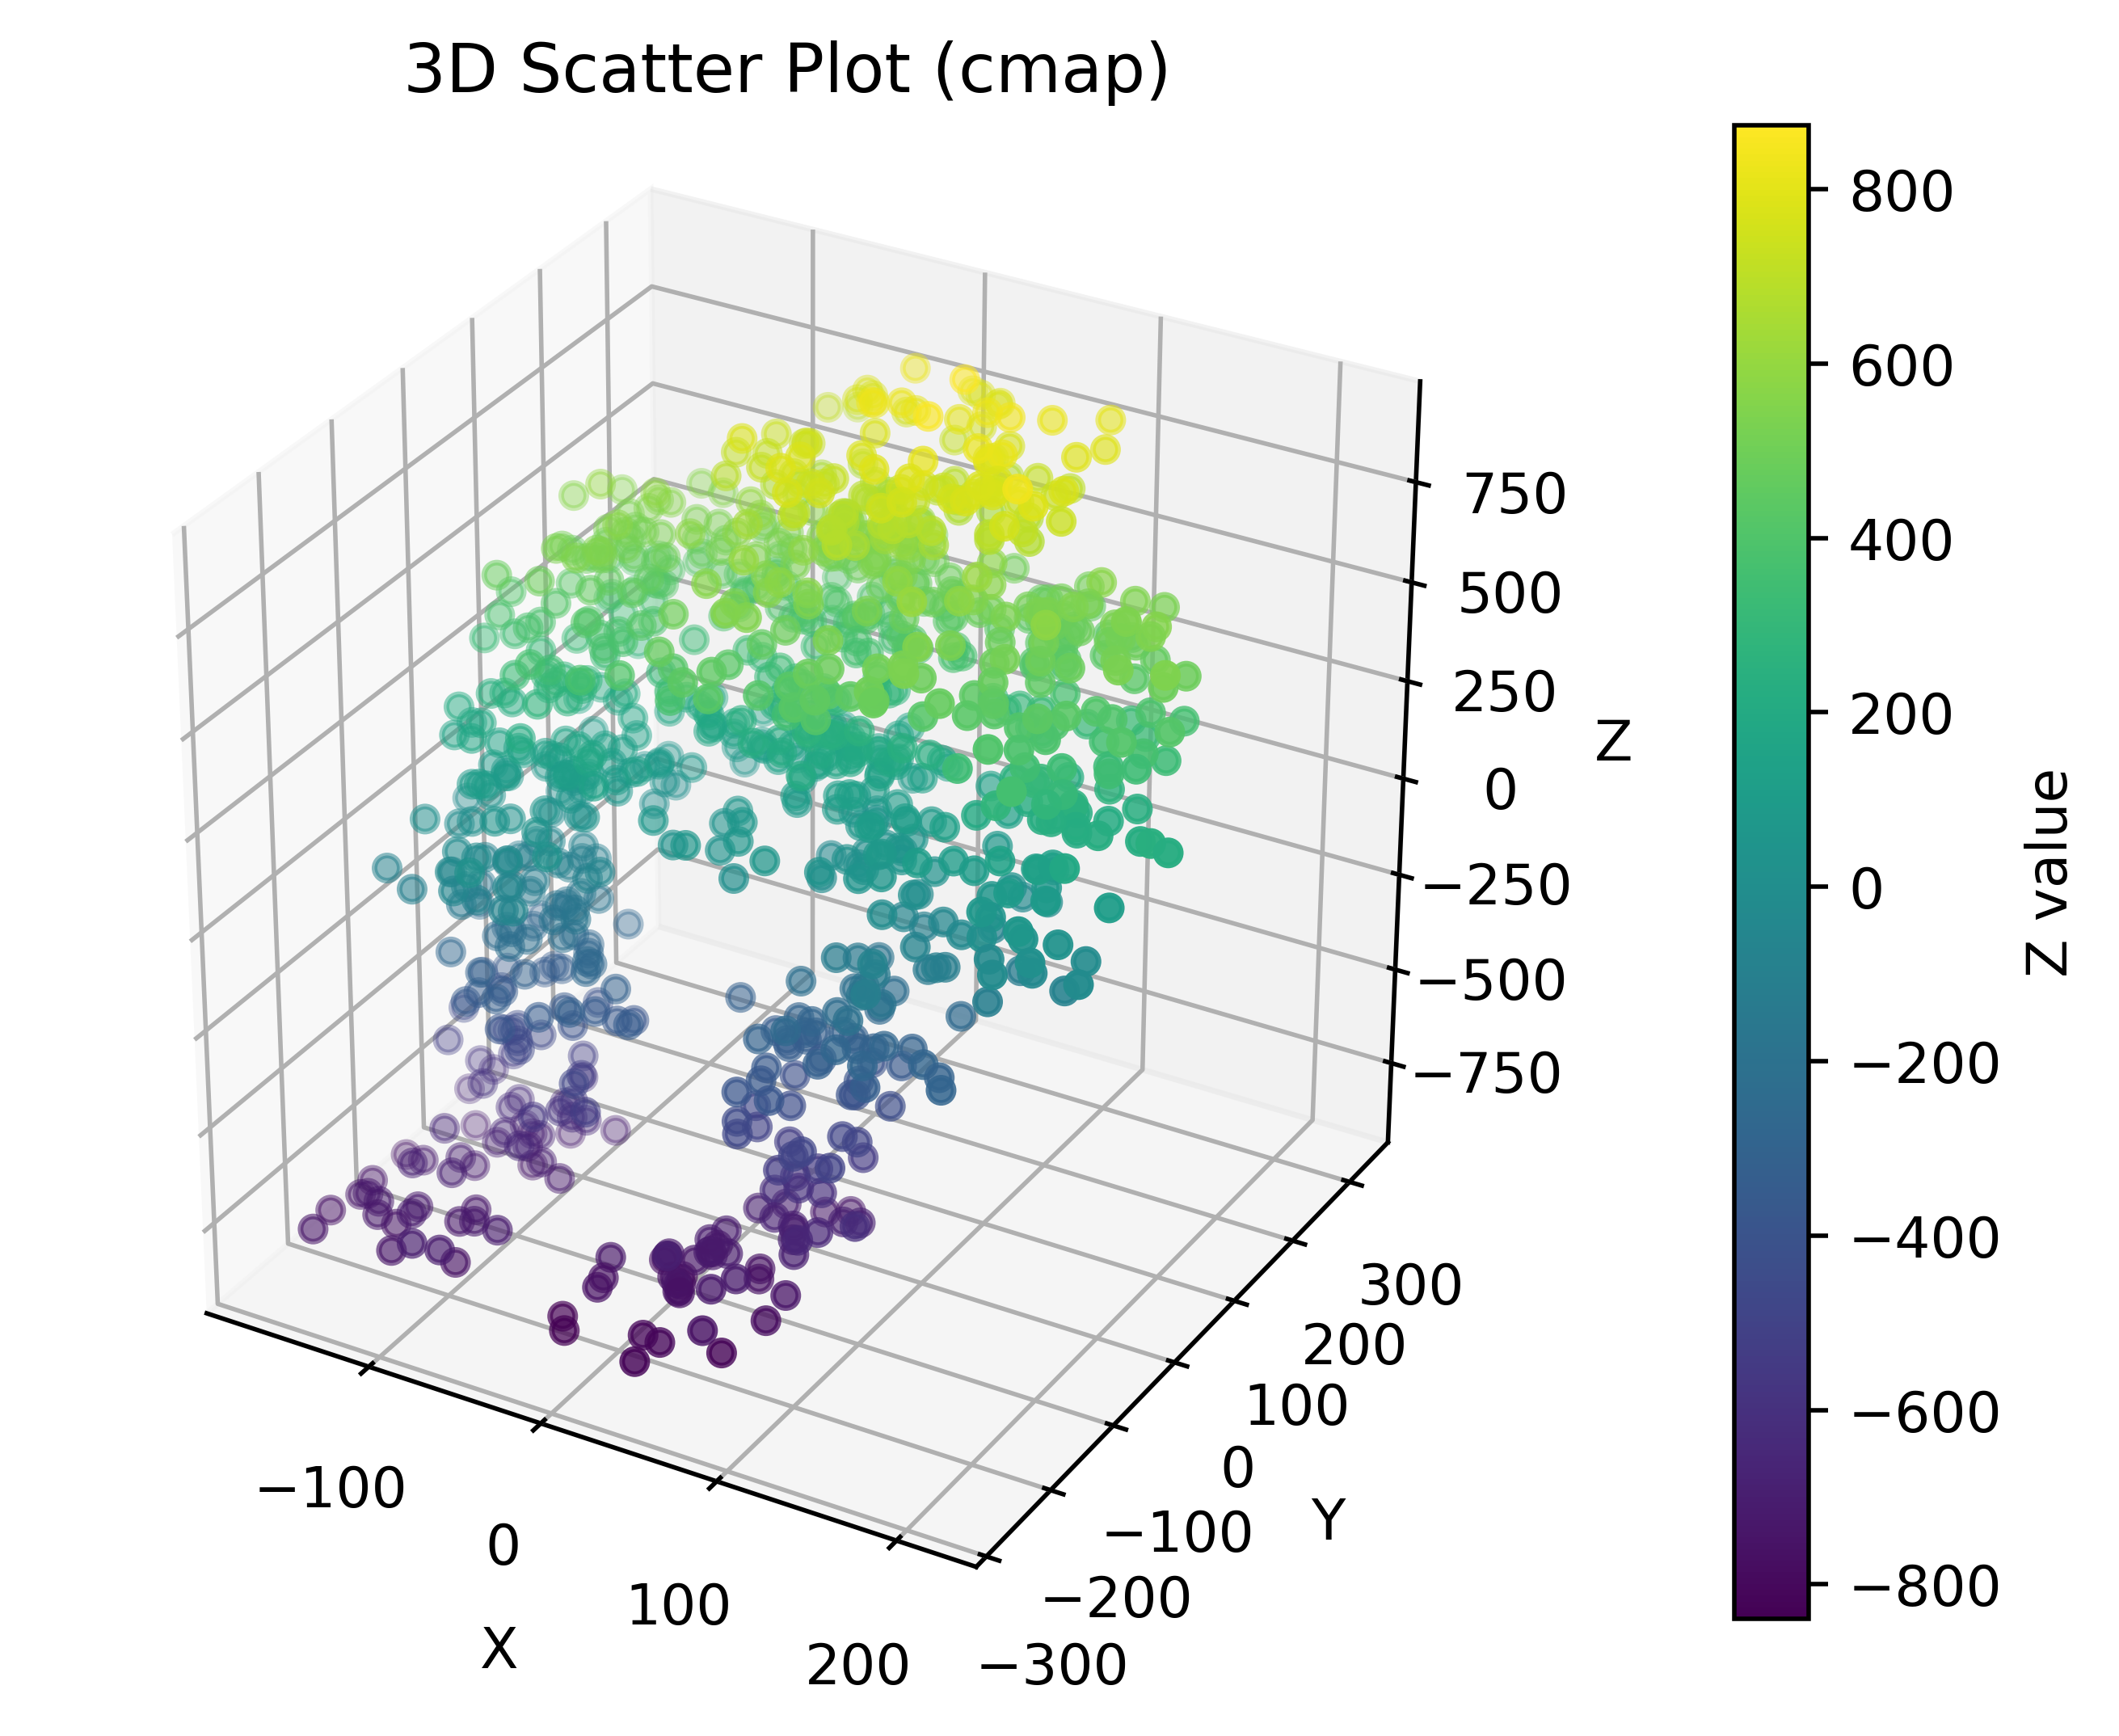

In [37]:
visualize_polygon_from_arr_using_plt(qsweep_reconstructed_points)

In [38]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(qsweep_reconstructed_points))
o3d.visualization.draw_geometries([pcd])

# Accuracy and Runtime comparisons

|![alt](figs/Accuracy.png) |![alt](figs/Runtime.png)|
|-|-|